100%|██████████| 9.91M/9.91M [00:00<00:00, 51.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.06MB/s]


Epoch [1/30]  D Loss: 0.6921, G Loss: 1.1579


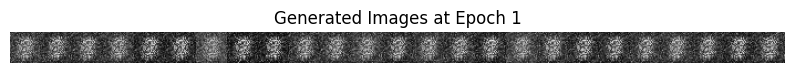

Epoch [2/30]  D Loss: 0.9452, G Loss: 0.9987
Epoch [3/30]  D Loss: 0.7825, G Loss: 1.3397
Epoch [4/30]  D Loss: 0.6547, G Loss: 1.4261
Epoch [5/30]  D Loss: 1.0897, G Loss: 0.9815


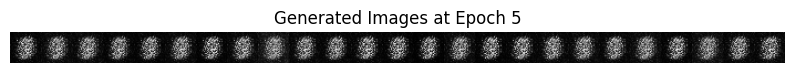

Epoch [6/30]  D Loss: 1.3776, G Loss: 0.7448
Epoch [7/30]  D Loss: 1.5254, G Loss: 0.8487
Epoch [8/30]  D Loss: 0.9731, G Loss: 1.2888
Epoch [9/30]  D Loss: 1.4568, G Loss: 0.7158
Epoch [10/30]  D Loss: 1.3275, G Loss: 0.8346


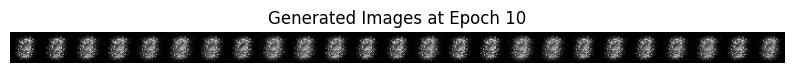

Epoch [11/30]  D Loss: 1.3375, G Loss: 1.0697
Epoch [12/30]  D Loss: 0.9293, G Loss: 1.1815
Epoch [13/30]  D Loss: 1.2617, G Loss: 0.9258
Epoch [14/30]  D Loss: 1.0817, G Loss: 1.0702
Epoch [15/30]  D Loss: 1.0016, G Loss: 1.0689


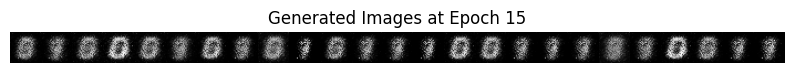

Epoch [16/30]  D Loss: 1.0997, G Loss: 0.8957
Epoch [17/30]  D Loss: 1.4331, G Loss: 0.8871
Epoch [18/30]  D Loss: 1.0480, G Loss: 1.0713
Epoch [19/30]  D Loss: 0.7995, G Loss: 1.3428
Epoch [20/30]  D Loss: 1.1577, G Loss: 1.2919


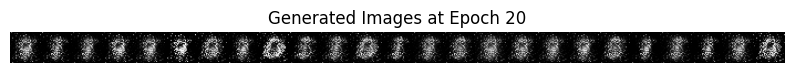

Epoch [21/30]  D Loss: 0.6481, G Loss: 1.3462
Epoch [22/30]  D Loss: 1.1724, G Loss: 1.1082
Epoch [23/30]  D Loss: 1.0579, G Loss: 0.9772
Epoch [24/30]  D Loss: 0.9756, G Loss: 1.0318
Epoch [25/30]  D Loss: 0.8226, G Loss: 1.2979


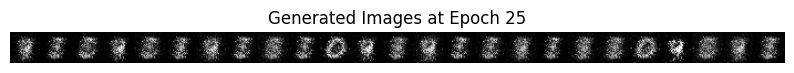

Epoch [26/30]  D Loss: 0.8735, G Loss: 1.4564
Epoch [27/30]  D Loss: 1.0004, G Loss: 2.0003
Epoch [28/30]  D Loss: 0.5839, G Loss: 2.3905
Epoch [29/30]  D Loss: 0.6613, G Loss: 2.0140
Epoch [30/30]  D Loss: 0.6551, G Loss: 1.7378


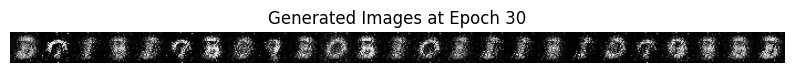

In [1]:
# Install dependencies (uncomment when running for the first time)
# !pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
batch_size = 64
lr = 0.0002
epochs = 30

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    datasets.MNIST(root='./data', train=True, transform=transform, download=True),
    batch_size=batch_size,
    shuffle=True
)

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x.view(-1, 784))

# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

# Function to display generated images
def show_images(fake_images, epoch):
    grid = fake_images[:25].detach().cpu()
    grid = grid.view(-1, 1, 28, 28)
    grid = torch.cat([img for img in grid], dim=2).squeeze().numpy()
    plt.figure(figsize=(10, 2))
    plt.title(f"Generated Images at Epoch {epoch}")
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

# Training loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)

        # Labels
        real_labels = torch.ones(batch_size_curr, 1).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size_curr, latent_dim).to(device)
        fake_images = G(z)
        real_loss = criterion(D(real_images), real_labels)
        fake_loss = criterion(D(fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size_curr, latent_dim).to(device)
        fake_images = G(z)
        g_loss = criterion(D(fake_images), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    if (epoch + 1) % 5 == 0 or epoch == 0:
        show_images(fake_images, epoch + 1)
